<a href="https://colab.research.google.com/github/VedantDere0104/GANs/blob/main/Conditional_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
########################

In [2]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.pyplot as plt
from  tqdm.auto import tqdm


In [44]:
def show_tensor_images(tensor_images , num_images = 25 , shape= (1 , 28 , 28) , nrows = 5 , show = True ):
  tensor_images = (tensor_images + 1) / 2
  image_unfalt = tensor_images.detach().cpu()
  image_grid = make_grid(image_unfalt[:num_images] , nrow= nrows)
  plt.imshow(image_grid.permute(1 , 2 , 0).squeeze())
  if show:
    plt.show()


In [45]:
class Generator(nn.Module):
 
    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
 
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):

        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

In [46]:
class Discriminator(nn.Module):
  def __init__(self , im_chan = 1 , hidden_dim = 64):
    super(Discriminator , self).__init__()
    self.disc = nn.Sequential(
        self.make_disc_block(im_chan , hidden_dim) , 
        self.make_disc_block(hidden_dim , hidden_dim * 2) , 
        self.make_disc_block(hidden_dim * 2 , 1 , final_layer = True)
    )

  def make_disc_block(self , input_dim , output_dim , kernel_size = 4 , stride = 2 , final_layer = False):
    if not final_layer:
      return nn.Sequential(
          nn.Conv2d(input_dim , output_dim , kernel_size , stride) , 
          nn.LeakyReLU(0.2 , inplace = True)
      )
    else :
      return nn.Sequential(
          nn.Conv2d(input_dim , output_dim , kernel_size , stride)
      )

  def forward(self , x):
    disc_pred = self.disc(x)
    return disc_pred.view(len(disc_pred) , -1)
    
    

In [47]:
def get_noise(num_images , z_dim , device):
  return torch.randn(num_images , z_dim).to(device)

In [48]:
def get_one_hot_labels(labels , n_classes):
  return F.one_hot(labels , n_classes)



In [49]:
def combine_vectors(x, y):
 
    combined = torch.cat((x.float(),y.float()),1)

    return combined

In [50]:
def get_input_dimensions(z_dim, mnist_shape, n_classes):

    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = mnist_shape[0] + n_classes

    return generator_input_dim, discriminator_im_chan

In [51]:

criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [52]:
cur_step = 0
generator_losses = []
discriminator_losses = []
noise_and_labels = False
fake = False
mnist_shape = (1, 28, 28)
n_classes = 10

In [53]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!



Step 500: Generator loss: 3.8566507345438, discriminator loss: 0.09198819973738864


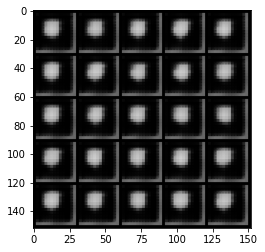

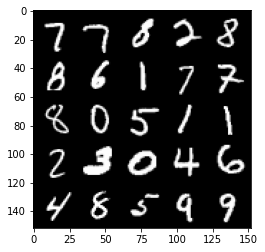

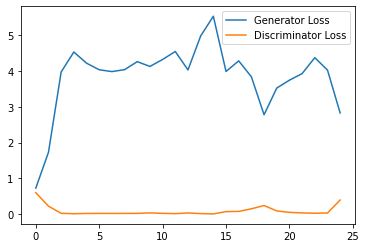

Step 1000: Generator loss: 3.7413694427013398, discriminator loss: 0.08378012123238296


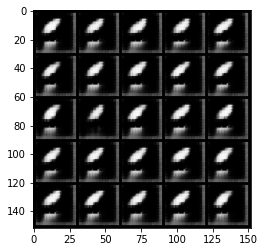

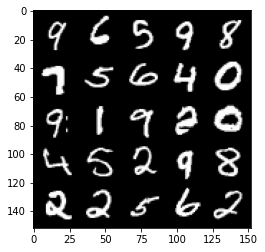

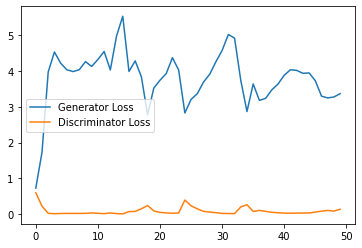

Step 1500: Generator loss: 2.9819093136787416, discriminator loss: 0.17838368722051381


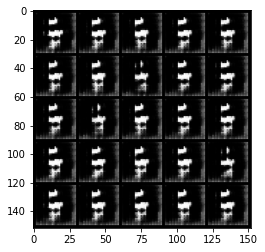

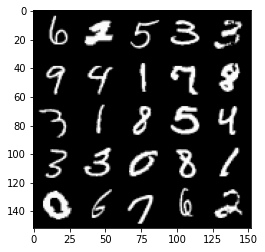

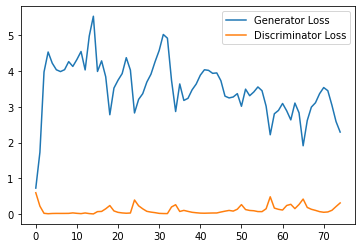

Step 2000: Generator loss: 2.6265273183584212, discriminator loss: 0.3215458230599761


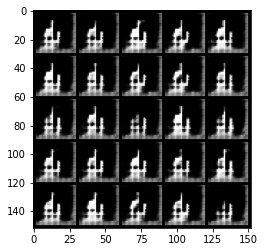

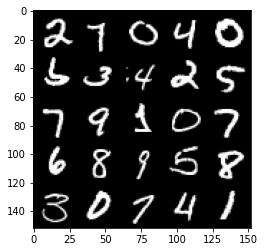

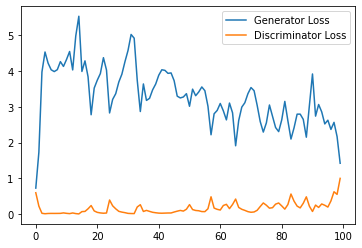

Step 2500: Generator loss: 2.8761133370399476, discriminator loss: 0.24823551799356938


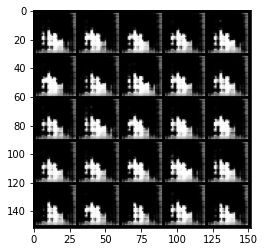

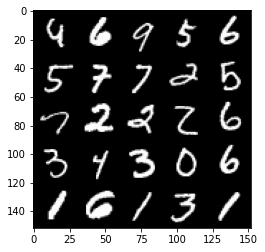

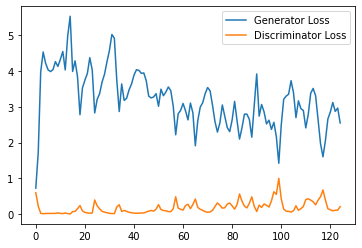

Step 3000: Generator loss: 2.504662026643753, discriminator loss: 0.2970664749071002


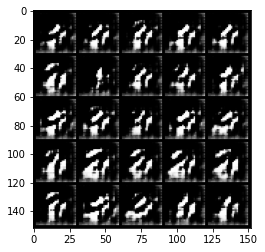

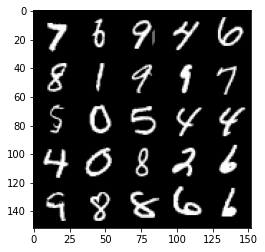

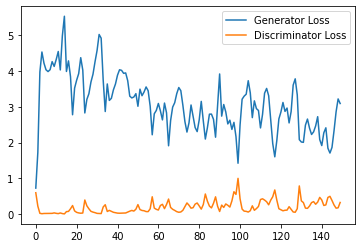

KeyboardInterrupt: ignored

In [54]:
for epoch in range(n_epochs):
  for real , label in tqdm(dataloader):
    cur_batch_size = len(real)
    real = real.to(device)
    one_hot_labels = get_one_hot_labels(label.to(device) , n_classes)
    image_one_hot_labels = one_hot_labels[: , : , None , None]
    image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])
    disc_opt.zero_grad()
    fake_noise = get_noise(cur_batch_size , z_dim , device)
    noise_and_labels = combine_vectors(fake_noise , one_hot_labels)
    fake = gen(noise_and_labels)
    fake_image_and_label = combine_vectors(fake , image_one_hot_labels)
    real_image_and_label = combine_vectors(real , image_one_hot_labels)
    disc_fake_pred = disc(fake_image_and_label)
    disc_real_pred = disc(real_image_and_label)
    disc_fake_loss = criterion(disc_fake_pred , torch.zeros_like(disc_fake_pred))
    disc_real_loss = criterion(disc_real_pred , torch.ones_like(disc_real_pred))
    disc_loss  = (disc_real_loss + disc_fake_loss)/2
    disc_loss.backward(retain_graph = True)
    disc_opt.step()
    
    discriminator_losses += [disc_loss.item()]

      
    gen_opt.zero_grad()

    fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
      
    disc_fake_pred = disc(fake_image_and_labels)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    gen_loss.backward()
    gen_opt.step()

        
    generator_losses += [gen_loss.item()]
 
    if cur_step % display_step == 0 and cur_step > 0:
        gen_mean = sum(generator_losses[-display_step:]) / display_step
        disc_mean = sum(discriminator_losses[-display_step:]) / display_step
        print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
        show_tensor_images(fake)
        show_tensor_images(real)
        step_bins = 20
        x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
        num_examples = (len(generator_losses) // step_bins) * step_bins
        plt.plot(
            range(num_examples // step_bins), 
            torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
            label="Generator Loss"
            )
        plt.plot(
            range(num_examples // step_bins), 
            torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
            label="Discriminator Loss"
            )
        plt.legend()
        plt.show()
    elif cur_step == 0:
      print("Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!")
    cur_step += 1

